# Version 3: 
- change preprocessing image part to train model with TPU which is faster than CPU 
- adding tune models and pre-trained models

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json

from kaggle_datasets import KaggleDatasets
import math, re, os

In [2]:
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print("Device:", tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()
# print("Number of replicas:", strategy.num_replicas_in_sync)

# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# I. EDA 

In [2]:
train_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
df_train=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
df_test=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')

In [3]:
df_train.shape

(33126, 8)

In [4]:
df_test.shape

(10982, 5)

**Desciption of valuables**

Train data has 8 features, 33126 observations and Test data 5 features, 10982 observations.

1. image name -> the filename of specific image for the train set
2. patient_id -> identifies the unique patient
3. sex -> gender of the patient
4. age_approx -> approx age of the patient at time of scanning
5. anatom_site_general_challenge -> location of the scan site
6. diagnosis -> information about the diagnosis
7. benign_malignant - indicates scan result if it's malignant or benign
8. target -> same as above but better for modelling since it's binary

In [5]:
df_train.head(10)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
5,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,0
6,ISIC_0074542,IP_4698288,male,25.0,lower extremity,unknown,benign,0
7,ISIC_0075663,IP_6017204,female,35.0,torso,unknown,benign,0
8,ISIC_0075914,IP_7622888,male,30.0,torso,unknown,benign,0
9,ISIC_0076262,IP_5075533,female,50.0,lower extremity,unknown,benign,0


In [6]:
df_test.head(10)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity
5,ISIC_0074618,IP_4438996,male,50.0,lower extremity
6,ISIC_0076801,IP_3110660,male,45.0,upper extremity
7,ISIC_0077586,IP_8578442,male,50.0,lower extremity
8,ISIC_0082004,IP_0817448,female,45.0,torso
9,ISIC_0082785,IP_3634181,male,65.0,lower extremity


In [7]:
df_train.describe(percentiles=[.1,.25,.50,.75,.95,.99])

,age_approx,target
count,33058.000000,33126.000000
mean,48.870016,0.017630
std,14.380360,0.131603
min,0.000000,0.000000
10%,30.000000,0.000000
25%,40.000000,0.000000
50%,50.000000,0.000000
75%,60.000000,0.000000
95%,70.000000,0.000000
99%,80.000000,1.000000


In [8]:
df_test.describe(percentiles=[.1,.25,.50,.75,.95,.99])

,age_approx
count,10982.000000
mean,49.525587
std,14.370589
min,10.000000
10%,30.000000
25%,40.000000
50%,50.000000
75%,60.000000
95%,75.000000
99%,85.000000


**Checking missing value**

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


In [11]:
# Missing values statistics in train
data_trans = df_train
total = data_trans.isnull().sum()
percent = data_trans.isnull().sum()/len(df_train)*100
missing_data = pd.concat([total,percent], axis=1,keys=['Total', 'Percent'])
missing_data

,Total,Percent
image_name,0,0.000000
patient_id,0,0.000000
sex,65,0.196220
age_approx,68,0.205277
anatom_site_general_challenge,527,1.590895
diagnosis,0,0.000000
benign_malignant,0,0.000000
target,0,0.000000


In [12]:
# Missing values statistics in test
total = df_test.isnull().sum()
percent = df_test.isnull().sum()/len(df_test)*100
missing_data = pd.concat([total,percent], axis=1,keys=['Total', 'Percent'])
missing_data

,Total,Percent
image_name,0,0.000000
patient_id,0,0.000000
sex,0,0.000000
age_approx,0,0.000000
anatom_site_general_challenge,351,3.196139


The anatomy shows most missing values.

**Image name**

In [13]:
df_train.image_name.value_counts().max()

1

In [14]:
df_test.image_name.value_counts().max()

1

all names are unique.

**Patient id counts**

In [15]:
df_train.patient_id.value_counts().max()

115

In [16]:
df_test.patient_id.value_counts().max()

240

Gender

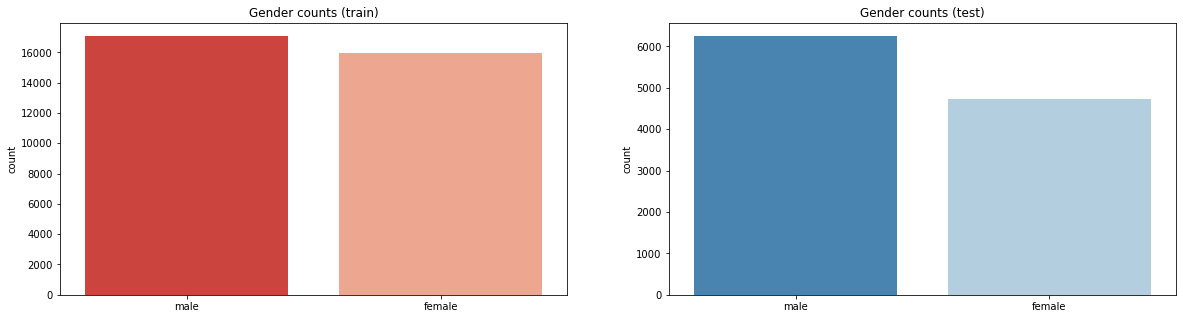

In [17]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(df_train.sex, palette="Reds_r", ax=ax[0]);
ax[0].set_xlabel("")
ax[0].set_title("Gender counts (train)");

sns.countplot(df_test.sex, palette="Blues_r", ax=ax[1]);
ax[1].set_xlabel("")
ax[1].set_title("Gender counts (test)");

*Insights*

- We observe more males than females in both train and test data.
- The surplus of males is even higher in test than in train!

Age distributions

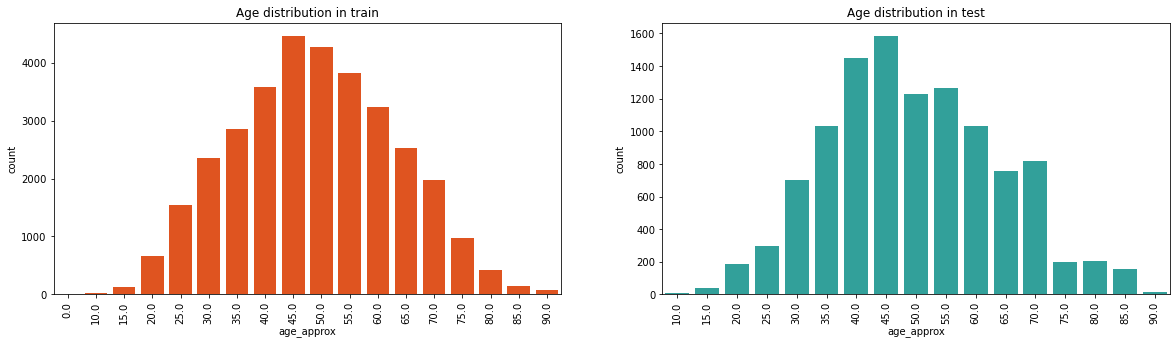

In [18]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

sns.countplot(df_train.age_approx, color="orangered", ax=ax[0]);
labels = ax[0].get_xticklabels();
ax[0].set_xticklabels(labels, rotation=90);
# ax[0].set_xlabel("");
ax[0].set_title("Age distribution in train");

sns.countplot(df_test.age_approx, color="lightseagreen", ax=ax[1]);
labels = ax[1].get_xticklabels();
ax[1].set_xticklabels(labels, rotation=90);
# ax[1].set_xlabel("");
ax[1].set_title("Age distribution in test");

*Insights*

- The age distribution in train looks almost normally distributed.
- In contrast, the age distribution in test shows multiple modes

**Image location**

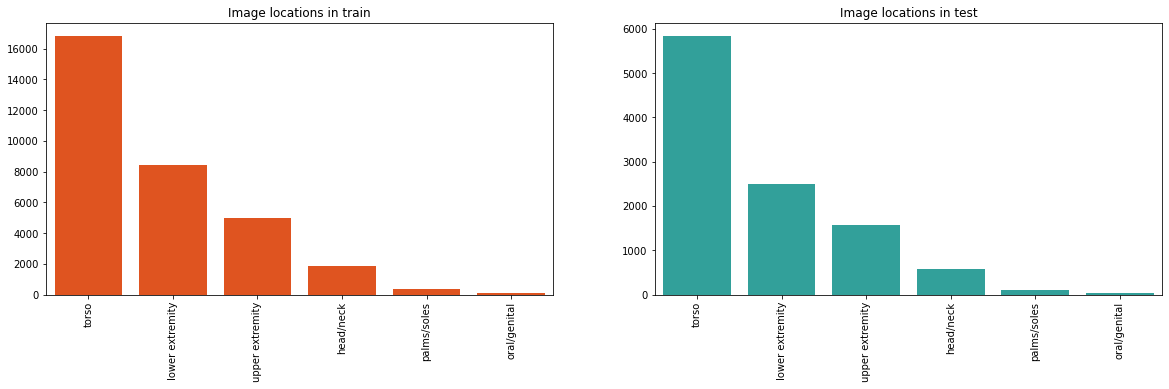

In [20]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

image_locations_train = df_train.anatom_site_general_challenge.value_counts().sort_values(ascending=False)
image_locations_test = df_test.anatom_site_general_challenge.value_counts().sort_values(ascending=False)

sns.barplot(x=image_locations_train.index.values, y=image_locations_train.values, ax=ax[0], color="orangered");
ax[0].set_xlabel("");
labels = ax[0].get_xticklabels();
ax[0].set_xticklabels(labels, rotation=90);
ax[0].set_title("Image locations in train");

sns.barplot(x=image_locations_test.index.values, y=image_locations_test.values, ax=ax[1], color="lightseagreen");
ax[1].set_xlabel("");
labels = ax[1].get_xticklabels();
ax[1].set_xticklabels(labels, rotation=90);
ax[1].set_title("Image locations in test");

*Insights*

- The distributions of image locations in train and test look very similar.
- Most images are related to the torso or to the lower extremity.

Target distribution

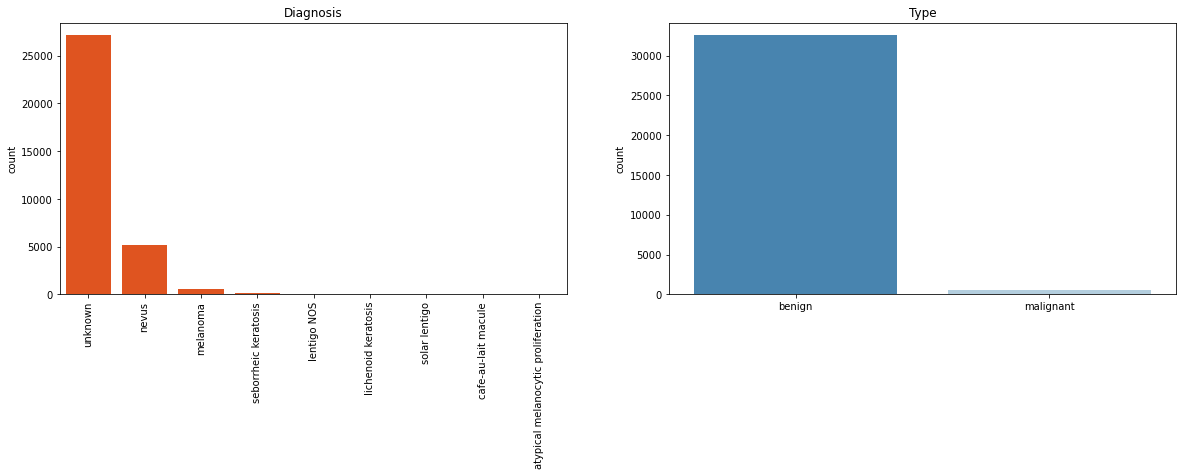

In [21]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

sns.countplot(x=df_train.diagnosis, orient="v", ax=ax[0], color="Orangered")
ax[0].set_xlabel("")
labels = ax[0].get_xticklabels();
ax[0].set_xticklabels(labels, rotation=90);
ax[0].set_title("Diagnosis");

sns.countplot(df_train.benign_malignant, ax=ax[1], palette="Blues_r");
ax[1].set_xlabel("")
ax[1].set_title("Type");

*Insights*

- The diagnosis is often unknown and for those known we observe a very high imbalance. Most likely we can't expect much from this additional target feature.
- The target is highly imbalanced and we have to find proper strategies to deal with this kind of target distribution during learning.

In [22]:
df_train.groupby("benign_malignant").target.nunique()

benign_malignant
benign       1
malignant    1
Name: target, dtype: int64

The benign_malignant column is the same as the target.

# Feature-feature interactions

Age and gender

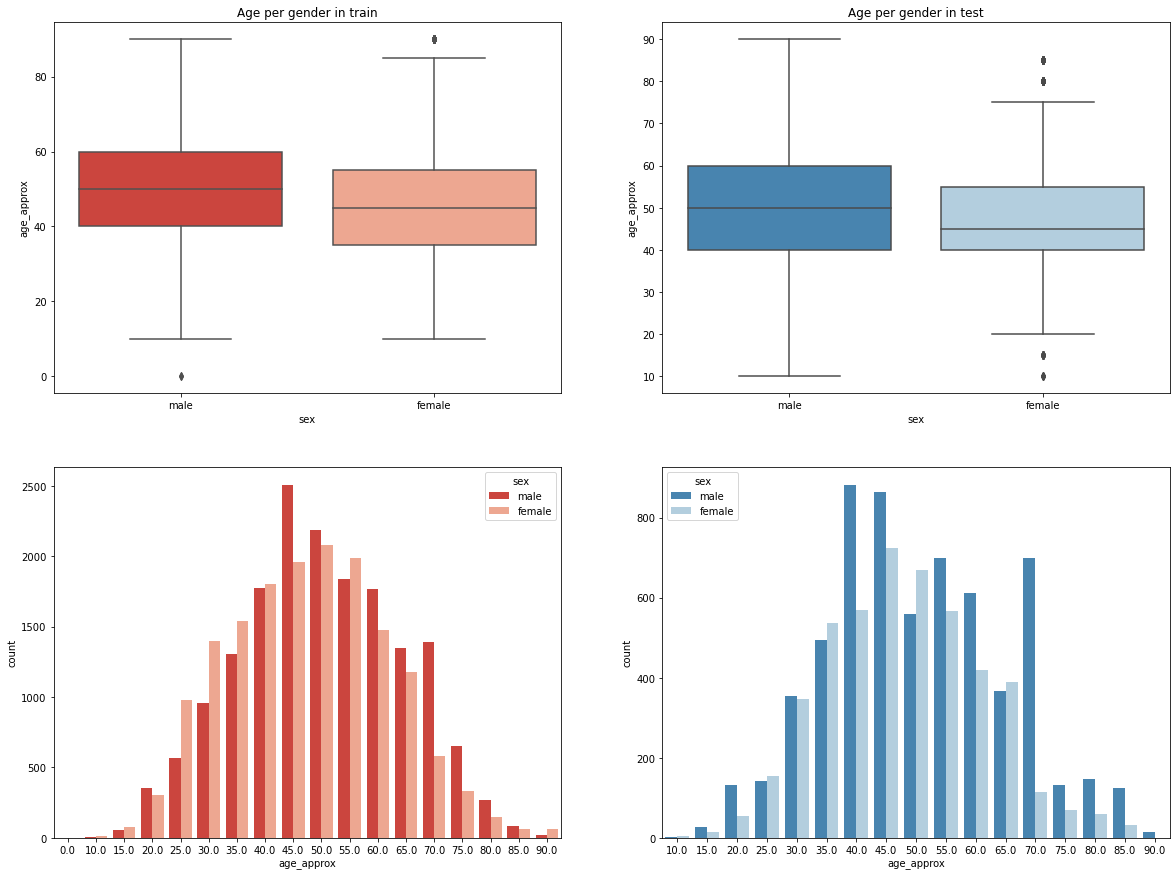

In [23]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

sns.boxplot(df_train.sex, df_train.age_approx, ax=ax[0,0], palette="Reds_r");
ax[0,0].set_title("Age per gender in train");

sns.boxplot(df_test.sex, df_test.age_approx, ax=ax[0,1], palette="Blues_r");
ax[0,1].set_title("Age per gender in test");

sns.countplot(df_train.age_approx, hue=df_train.sex, ax=ax[1,0], palette="Reds_r");
sns.countplot(df_test.age_approx, hue=df_test.sex, ax=ax[1,1], palette="Blues_r");

*Insights*

There are some significant differences in train and test regarding the gender per age level:

- At the ages between 25 and 35 we have much more females than males in train but a balanced count in test!
- We can observe a high surplus of males in the ages 45 to 50 and 70, 75 in train and test but in test we can find even more males of high age > 75.

Age, gender and cancer

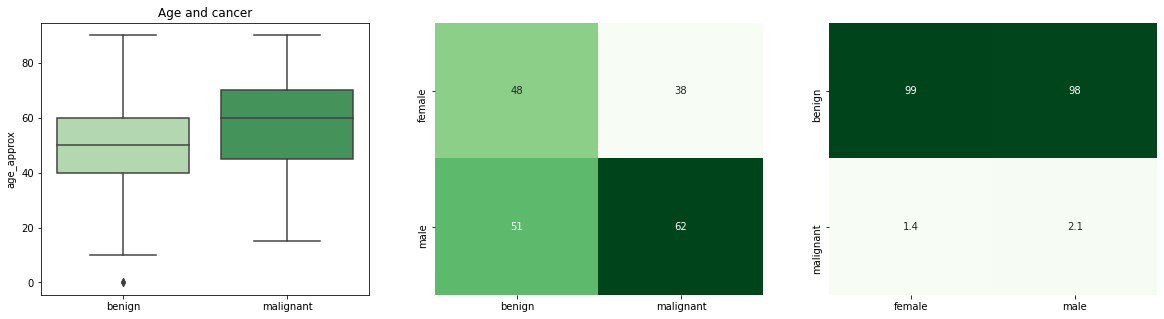

In [24]:
sex_and_cancer_map = df_train.groupby(
    ["benign_malignant", "sex"]
).size().unstack(level=0) / df_train.groupby("benign_malignant").size() * 100

cancer_sex_map = df_train.groupby(
    ["benign_malignant", "sex"]
).size().unstack(level=1) / df_train.groupby("sex").size() * 100


fig, ax = plt.subplots(1,3,figsize=(20,5))

sns.boxplot(df_train.benign_malignant, df_train.age_approx, ax=ax[0], palette="Greens");
ax[0].set_title("Age and cancer");
ax[0].set_xlabel("");

sns.heatmap(sex_and_cancer_map, annot=True, cmap="Greens", cbar=False, ax=ax[1])
ax[1].set_xlabel("")
ax[1].set_ylabel("");

sns.heatmap(cancer_sex_map, annot=True, cmap="Greens", cbar=False, ax=ax[2])
ax[2].set_xlabel("")
ax[2].set_ylabel("");

*Insights*

- We have more malignant cases of higher age than benign cases.
- 62 % of the malignant cases belong to males and only 38 % to females.
- Roughly 2 % of the males in the train dataset show malignant cases, but only 1.4 % of the females.

We have to be very careful!!! As we have a surpus of males with ages above 70 and 75 it's unclear if the sex is really an important feature for having melanoma or not. It could also be that the age is most important and that we only have more malignant cases for males due to their higher age!

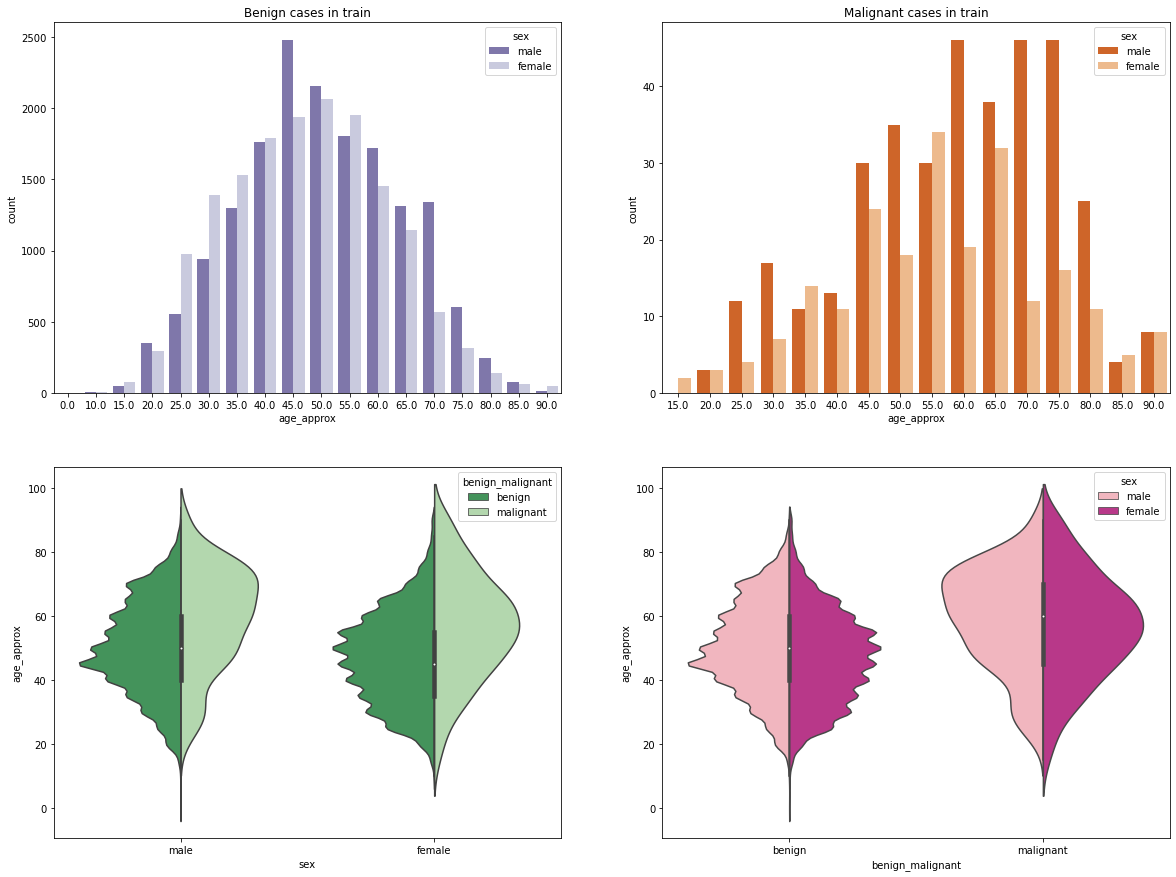

In [25]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

sns.countplot(df_train[df_train.benign_malignant=="benign"].age_approx, hue=df_train.sex, palette="Purples_r", ax=ax[0,0])
ax[0,0].set_title("Benign cases in train");

sns.countplot(df_train[df_train.benign_malignant=="malignant"].age_approx, hue=df_train.sex, palette="Oranges_r", ax=ax[0,1])
ax[0,1].set_title("Malignant cases in train");

sns.violinplot(df_train.sex, df_train.age_approx, hue=df_train.benign_malignant, split=True, ax=ax[1,0], palette="Greens_r");
sns.violinplot(df_train.benign_malignant, df_train.age_approx, hue=df_train.sex, split=True, ax=ax[1,1], palette="RdPu");

*Insights*

- For the benign cases we can see that there is still a surplus of males in the ages of 45 and 70, but the other ones look quite good and balanced.

- In contrast we can find a high gender imbalance for a wide range of ages for the malignant cases! That's really interesting and the features age and gender as well as their interaction with cancer are definitely some to play with during modelling.

**Individual patient information:**

Let's collect some information for each patient:

- the number of recorded images
- the gender
- the number of benign & malignant cases
- the minimum and maximum age of a patient with malignant cases

In [26]:
patient_gender_train = df_train.groupby("patient_id").sex.unique().apply(lambda l: l[0])
patient_gender_test = df_test.groupby("patient_id").sex.unique().apply(lambda l: l[0])

train_patients = pd.DataFrame(index=patient_gender_train.index.values, data=patient_gender_train.values, columns=["sex"])
test_patients = pd.DataFrame(index=patient_gender_test.index.values, data=patient_gender_test.values, columns=["sex"])

train_patients.loc[:, "num_images"] = df_train.groupby("patient_id").size()
test_patients.loc[:, "num_images"] = df_test.groupby("patient_id").size()

train_patients.loc[:, "min_age"] = df_train.groupby("patient_id").age_approx.min()
train_patients.loc[:, "max_age"] = df_train.groupby("patient_id").age_approx.max()
test_patients.loc[:, "min_age"] = df_test.groupby("patient_id").age_approx.min()
test_patients.loc[:, "max_age"] = df_test.groupby("patient_id").age_approx.max()

train_patients.loc[:, "age_span"] = train_patients["max_age"] - train_patients["min_age"]
test_patients.loc[:, "age_span"] = test_patients["max_age"] - test_patients["min_age"]

train_patients.loc[:, "benign_cases"] = df_train.groupby(["patient_id", "benign_malignant"]).size().loc[:, "benign"]
train_patients.loc[:, "malignant_cases"] = df_train.groupby(["patient_id", "benign_malignant"]).size().loc[:, "malignant"]
train_patients["min_age_malignant"] = df_train.groupby(["patient_id", "benign_malignant"]).age_approx.min().loc[:, "malignant"]
train_patients["max_age_malignant"] = df_train.groupby(["patient_id", "benign_malignant"]).age_approx.max().loc[:, "malignant"]

In [27]:
train_patients.sort_values(by="malignant_cases", ascending=False).head()

,sex,num_images,min_age,max_age,age_span,benign_cases,malignant_cases,min_age_malignant,max_age_malignant
IP_7373371,female,42,55.0,60.0,5.0,34.0,8.0,55.0,60.0
IP_9111321,male,13,60.0,60.0,0.0,7.0,6.0,60.0,60.0
IP_2412574,male,23,65.0,70.0,5.0,18.0,5.0,65.0,70.0
IP_3237442,male,8,65.0,85.0,20.0,3.0,5.0,65.0,80.0
IP_9037179,male,7,70.0,75.0,5.0,3.0,4.0,70.0,70.0


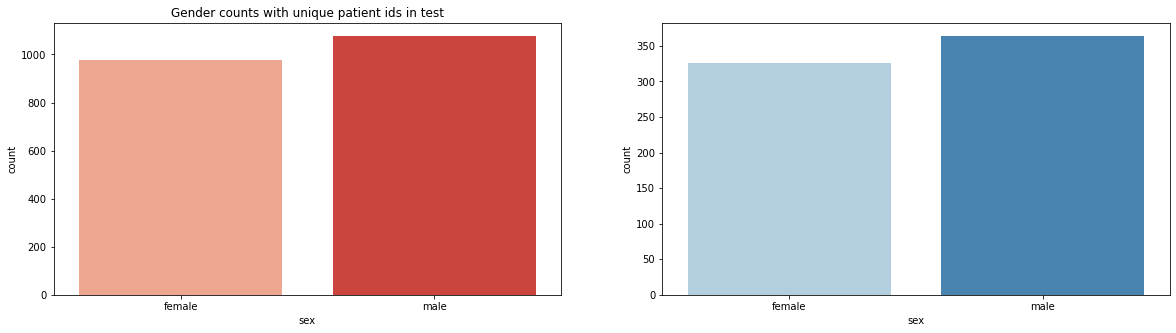

In [28]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(train_patients.sex, ax=ax[0], palette="Reds")
ax[0].set_title("Gender counts with unique patient ids in train")
sns.countplot(test_patients.sex, ax=ax[1], palette="Blues");
ax[0].set_title("Gender counts with unique patient ids in test");

*Insights*

- Even on the patient id level we have more males than females in both train and test data.

# II. Preprocessing image

In [29]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE
AUTO = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')
IMAGE_SIZE = [1024, 1024]
BATCH_SIZE = 32
imSize = 256
# AUTO = AUTOTUNE
# TRAINING_FILENAMES = glob.glob("/kaggle/input/siim-isic-melanoma-classification/tfrecords/train*")
# TRAINING_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords/train*')
# # TEST_FILENAMES = glob.glob("/kaggle/input/siim-isic-melanoma-classification/tfrecords/test*")
# TEST_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords/test*')
# BATCH_SIZE = 10 * strategy.num_replicas_in_sync

In [30]:
FILENAMES = tf.io.gfile.glob(GCS_PATH + "/tfrecords/train*.tfrec")
split_ind = int(0.9 * len(FILENAMES))
TRAINING_FILENAMES, VALID_FILENAMES = FILENAMES[:split_ind], FILENAMES[split_ind:]

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + "/tfrecords/test*.tfrec")
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

Train TFRecord Files: 14
Validation TFRecord Files: 2
Test TFRecord Files: 16


In [31]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
#     image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    image = tf.image.resize(image, [imSize,imSize])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['target'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_dataset(filenames):
    dataset = load_dataset(filenames, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALID_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
VALIDATION_STEP = int(NUM_VALID_IMAGES / BATCH_SIZE)
STEPS_PER_EPOCH = int(NUM_TRAINING_IMAGES / BATCH_SIZE)  
print('Dataset: {} training images, {} valid images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES,NUM_VALID_IMAGES, NUM_TEST_IMAGES))

Dataset: 28994 training images, 4132 valid images, 10982 unlabeled test images


In [32]:
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_test_dataset(ordered=True)

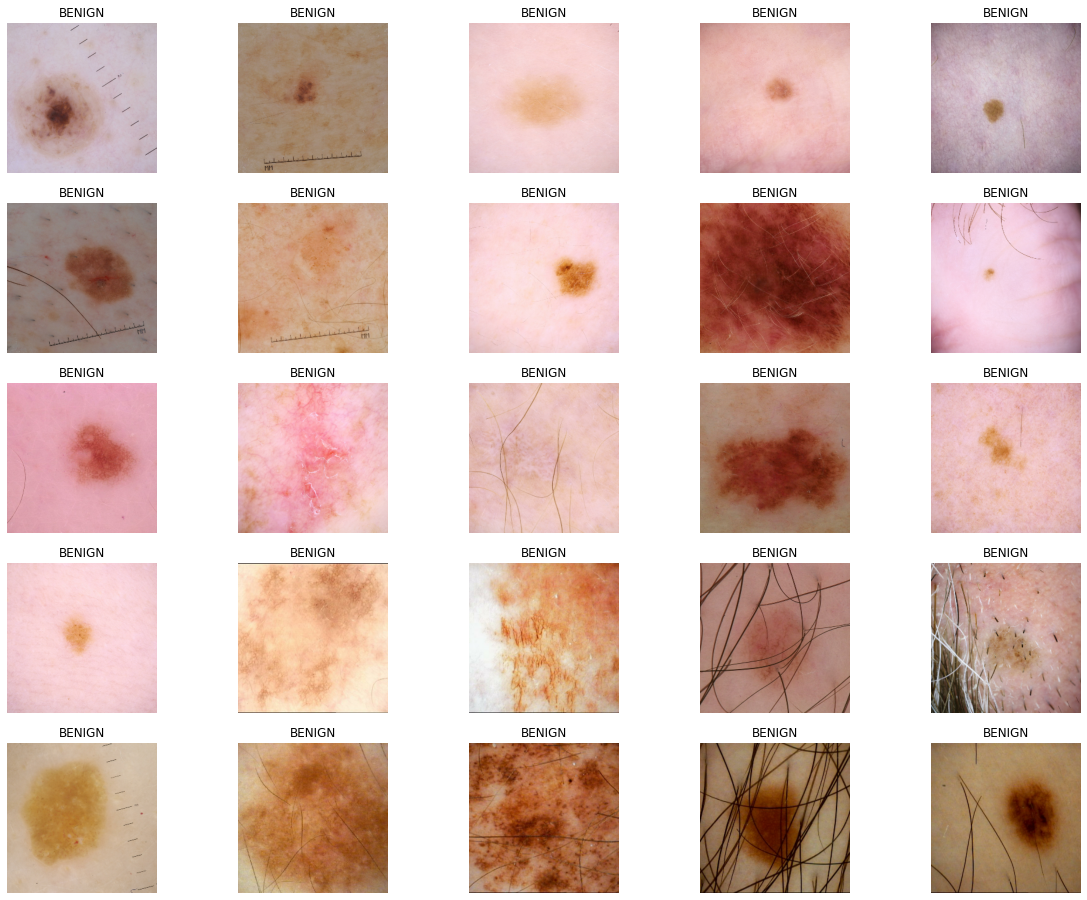

In [33]:
image_batch, label_batch = next(iter(train_dataset))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20, 16))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
#         plt.imshow(image_batch[n] / 255.0)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("MALIGNANT")
        else:
            plt.title("BENIGN")
        plt.axis("off")


show_batch(image_batch.numpy(), label_batch.numpy())

# III. Build Model

In [8]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "melanoma_model.h5", save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [9]:
def make_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                            input_shape=(imSize, imSize, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2),strides=2))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2),strides=2))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=512, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
#     model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    return model

In [10]:
def train_model(epoch):
    with strategy.scope():
        model = make_model()
    #     model.summary()
        model.compile(
            optimizer='adam',
            loss = 'binary_crossentropy',
            metrics=['accuracy']
        )
    history = model.fit(
    train_dataset,
#     steps_per_epoch=100,
    steps_per_epoch= STEPS_PER_EPOCH,
    epochs=epoch,
    validation_data=valid_dataset,
#     validation_steps = 10,
    validation_steps= VALIDATION_STEP,
    callbacks=[checkpoint_cb, early_stopping_cb]
    )
    return model

### model1: image size = 256, batch size = 32

In [14]:
EPOCH = 10
model = train_model(EPOCH)

Epoch 1/10
906/906 [==============================] - 52s 57ms/step - accuracy: 0.9811 - loss: 0.0948 - val_accuracy: 0.9816 - val_loss: 0.0884
Epoch 2/10
906/906 [==============================] - 40s 45ms/step - accuracy: 0.9826 - loss: 0.0871 - val_accuracy: 0.9816 - val_loss: 0.0928
Epoch 3/10
906/906 [==============================] - 42s 46ms/step - accuracy: 0.9826 - loss: 0.0871 - val_accuracy: 0.9813 - val_loss: 0.0900
Epoch 4/10
906/906 [==============================] - 38s 42ms/step - accuracy: 0.9822 - loss: 0.0879 - val_accuracy: 0.9823 - val_loss: 0.0857
Epoch 5/10
906/906 [==============================] - 41s 45ms/step - accuracy: 0.9825 - loss: 0.0859 - val_accuracy: 0.9838 - val_loss: 0.0816
Epoch 6/10
906/906 [==============================] - 42s 46ms/step - accuracy: 0.9831 - loss: 0.0834 - val_accuracy: 0.9818 - val_loss: 0.1504
Epoch 7/10
906/906 [==============================] - 37s 41ms/step - accuracy: 0.9823 - loss: 0.0894 - val_accuracy: 0.9835 - val_loss:

In [15]:
model.save('model1.h5')

In [11]:
def prediction():
    y_val=[]
    y_pred = []
    # max_iter = int(NUM_TRAINING_IMAGES / BATCH_SIZE)
    max_iter = int(NUM_VALID_IMAGES / BATCH_SIZE)
    # valid_dataset = get_dataset(VALID_FILENAMES)
    for i in range(max_iter):
        image_batch, label_batch = next(iter(valid_dataset))
        y_val = np.concatenate((y_val,label_batch.numpy()))
        y_pred = np.concatenate((y_pred,model.predict(image_batch).flatten()))
    return y_val, y_pred   

def gini_score(y_true, y_pred):
    auc_gbc = roc_auc_score(y_true, y_pred)
    print('auc: '+ str(auc_gbc))
    gini_gbc = 2*auc_gbc - 1
    print('gini: ' + str(gini_gbc))

In [19]:
y_val, y_pred = prediction()

In [21]:
gini_score(y_val, y_pred)    

auc: 0.7128706979991432
gini: 0.4257413959982863


## Tune Model

### model 2: change batch size from 32 to 16, image size = 256

In [22]:
imSize = 256
BATCH_SIZE = 16 # update validation_step and steps per epoch
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_test_dataset(ordered=True)
VALIDATION_STEP = int(NUM_VALID_IMAGES / BATCH_SIZE)
STEPS_PER_EPOCH = int(NUM_TRAINING_IMAGES / BATCH_SIZE)  
EPOCH = 10

In [23]:
model = train_model(EPOCH)  

Epoch 1/10
1812/1812 [==============================] - 57s 32ms/step - accuracy: 0.9823 - loss: 0.0945 - val_accuracy: 0.9826 - val_loss: 0.0873
Epoch 2/10
1812/1812 [==============================] - 55s 31ms/step - accuracy: 0.9821 - loss: 0.0902 - val_accuracy: 0.9823 - val_loss: 0.0862
Epoch 3/10
1812/1812 [==============================] - 57s 31ms/step - accuracy: 0.9825 - loss: 0.0865 - val_accuracy: 0.9823 - val_loss: 0.0874
Epoch 4/10
1812/1812 [==============================] - 57s 31ms/step - accuracy: 0.9824 - loss: 0.0919 - val_accuracy: 0.9813 - val_loss: 0.1011
Epoch 5/10
1812/1812 [==============================] - 56s 31ms/step - accuracy: 0.9825 - loss: 0.1042 - val_accuracy: 0.9816 - val_loss: 0.0878
Epoch 6/10
1812/1812 [==============================] - 57s 32ms/step - accuracy: 0.9826 - loss: 0.0933 - val_accuracy: 0.9813 - val_loss: 0.0895
Epoch 7/10
1812/1812 [==============================] - 57s 32ms/step - accuracy: 0.9825 - loss: 0.0853 - val_accuracy: 0.98

In [24]:
model.save('model2.h5')

In [25]:
y_val, y_pred = prediction()

In [26]:
gini_score(y_val, y_pred)

auc: 0.7332446481299213
gini: 0.4664892962598426


### model 3: change image size from 256 to 512, batch size = 16

In [27]:
imSize = 512
BATCH_SIZE = 16 
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_test_dataset(ordered=True)
VALIDATION_STEP = int(NUM_VALID_IMAGES / BATCH_SIZE)
STEPS_PER_EPOCH = int(NUM_TRAINING_IMAGES / BATCH_SIZE) 
EPOCH = 10

In [28]:
model = train_model(EPOCH)

Epoch 1/10
1812/1812 [==============================] - 104s 57ms/step - accuracy: 0.9825 - loss: 0.0992 - val_accuracy: 0.9813 - val_loss: 0.0930
Epoch 2/10
1812/1812 [==============================] - 101s 56ms/step - accuracy: 0.9824 - loss: 0.0913 - val_accuracy: 0.9821 - val_loss: 0.0900
Epoch 3/10
1812/1812 [==============================] - 102s 57ms/step - accuracy: 0.9826 - loss: 0.0898 - val_accuracy: 0.9823 - val_loss: 0.0896
Epoch 4/10
1812/1812 [==============================] - 101s 56ms/step - accuracy: 0.9825 - loss: 0.0902 - val_accuracy: 0.9826 - val_loss: 0.0880
Epoch 5/10
1812/1812 [==============================] - 103s 57ms/step - accuracy: 0.9826 - loss: 0.0896 - val_accuracy: 0.9830 - val_loss: 0.0861
Epoch 6/10
1812/1812 [==============================] - 102s 56ms/step - accuracy: 0.9825 - loss: 0.0893 - val_accuracy: 0.9811 - val_loss: 0.0938
Epoch 7/10
1812/1812 [==============================] - 101s 56ms/step - accuracy: 0.9825 - loss: 0.0895 - val_accurac

In [29]:
model.save('model3.h5')

In [30]:
y_val, y_pred = prediction()

In [31]:
gini_score(y_val, y_pred)

auc: 0.4729249762583096
gini: -0.054150047483380814


### model 4: image size = 512, batch size = 32

In [32]:
imSize = 512
BATCH_SIZE = 32 
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_test_dataset(ordered=True)
VALIDATION_STEP = int(NUM_VALID_IMAGES / BATCH_SIZE)
STEPS_PER_EPOCH = int(NUM_TRAINING_IMAGES / BATCH_SIZE) 
EPOCH = 10

In [33]:
model = train_model(EPOCH)

Epoch 1/10
906/906 [==============================] - 82s 91ms/step - accuracy: 0.9806 - loss: 0.1144 - val_accuracy: 0.9813 - val_loss: 0.0905
Epoch 2/10
906/906 [==============================] - 78s 87ms/step - accuracy: 0.9824 - loss: 0.0891 - val_accuracy: 0.9838 - val_loss: 0.0810
Epoch 3/10
906/906 [==============================] - 78s 86ms/step - accuracy: 0.9825 - loss: 0.0871 - val_accuracy: 0.9818 - val_loss: 0.0876
Epoch 4/10
906/906 [==============================] - 78s 86ms/step - accuracy: 0.9820 - loss: 0.0893 - val_accuracy: 0.9818 - val_loss: 0.0880
Epoch 5/10
906/906 [==============================] - 78s 86ms/step - accuracy: 0.9827 - loss: 0.0847 - val_accuracy: 0.9823 - val_loss: 0.0852
Epoch 6/10
906/906 [==============================] - 78s 86ms/step - accuracy: 0.9828 - loss: 0.0852 - val_accuracy: 0.9823 - val_loss: 0.0916
Epoch 7/10
906/906 [==============================] - 78s 86ms/step - accuracy: 0.9821 - loss: 0.0884 - val_accuracy: 0.9826 - val_loss:

In [34]:
model.save('model4.h5')

In [35]:
y_val, y_pred = prediction()

In [36]:
gini_score(y_val, y_pred)

auc: 0.7359632518717675
gini: 0.47192650374353495


**compare gini score among above models, chosing model with image size = 512, batch size = 32 to continue tuning this model**

### Model 5: image size = 512, batch size = 32, change EPOCH into 20

In [40]:
imSize = 512
BATCH_SIZE = 32 
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_test_dataset(ordered=True)
VALIDATION_STEP = int(NUM_VALID_IMAGES / BATCH_SIZE)
STEPS_PER_EPOCH = int(NUM_TRAINING_IMAGES / BATCH_SIZE) 
EPOCH = 20

In [44]:
model = train_model(EPOCH)

Epoch 1/20
906/906 [==============================] - 79s 87ms/step - loss: 0.0928 - accuracy: 0.9813 - val_loss: 0.1012 - val_accuracy: 0.9806
Epoch 2/20
906/906 [==============================] - 76s 84ms/step - loss: 0.0867 - accuracy: 0.9824 - val_loss: 0.0917 - val_accuracy: 0.9816
Epoch 3/20
906/906 [==============================] - 77s 85ms/step - loss: 0.0866 - accuracy: 0.9827 - val_loss: 0.0880 - val_accuracy: 0.9813
Epoch 4/20
906/906 [==============================] - 77s 85ms/step - loss: 0.0865 - accuracy: 0.9824 - val_loss: 0.0878 - val_accuracy: 0.9813
Epoch 5/20
906/906 [==============================] - 78s 86ms/step - loss: 0.0853 - accuracy: 0.9824 - val_loss: 0.0792 - val_accuracy: 0.9833
Epoch 6/20
906/906 [==============================] - 77s 85ms/step - loss: 0.0834 - accuracy: 0.9826 - val_loss: 0.0889 - val_accuracy: 0.9813
Epoch 7/20
906/906 [==============================] - 77s 85ms/step - loss: 0.0836 - accuracy: 0.9827 - val_loss: 0.0807 - val_accuracy:

In [45]:
model.save('model5.h5')

In [46]:
y_val, y_pred = prediction()

In [47]:
gini_score(y_val, y_pred)

auc: 0.7612159653465347
gini: 0.5224319306930694


### Model 6: image size = 1024, batch size = 32, EPOCH = 10

In [15]:
imSize = 1024
BATCH_SIZE = 32 
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_test_dataset(ordered=True)
VALIDATION_STEP = int(NUM_VALID_IMAGES / BATCH_SIZE)
STEPS_PER_EPOCH = int(NUM_TRAINING_IMAGES / BATCH_SIZE) 
EPOCH = 10

In [16]:
model = train_model(EPOCH)

Epoch 1/10
906/906 [==============================] - 219s 242ms/step - loss: 0.1089 - accuracy: 0.9801 - val_loss: 0.1180 - val_accuracy: 0.9823
Epoch 2/10
906/906 [==============================] - 219s 241ms/step - loss: 0.0886 - accuracy: 0.9827 - val_loss: 0.0863 - val_accuracy: 0.9828
Epoch 3/10
906/906 [==============================] - 195s 215ms/step - loss: 0.0857 - accuracy: 0.9828 - val_loss: 0.1064 - val_accuracy: 0.9809
Epoch 4/10
906/906 [==============================] - 193s 212ms/step - loss: 0.0881 - accuracy: 0.9822 - val_loss: 0.0979 - val_accuracy: 0.9828
Epoch 5/10
906/906 [==============================] - 205s 226ms/step - loss: 0.0866 - accuracy: 0.9824 - val_loss: 0.0852 - val_accuracy: 0.9821
Epoch 6/10
906/906 [==============================] - 194s 214ms/step - loss: 0.0847 - accuracy: 0.9826 - val_loss: 0.0868 - val_accuracy: 0.9816
Epoch 7/10
906/906 [==============================] - 192s 212ms/step - loss: 0.0870 - accuracy: 0.9828 - val_loss: 0.0894 -

In [18]:
y_val, y_pred = prediction()

In [19]:
gini_score(y_val, y_pred)

auc: 0.7193253197979335
gini: 0.4386506395958669


# IIII. Pre_trained model

### Pre_trained Model 1: image size = 512, batch size = 32

In [37]:
imSize = 512
BATCH_SIZE = 32 
VALIDATION_STEP = int(NUM_VALID_IMAGES / BATCH_SIZE)
STEPS_PER_EPOCH = int(NUM_TRAINING_IMAGES / BATCH_SIZE) 
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_test_dataset(ordered=True)
EPOCH = 10

In [14]:
# use pre trained model Xception
def make_pretrained_model():
    base_model = tf.keras.applications.Xception(
        input_shape=(imSize,imSize, 3), include_top=False, weights="imagenet"
    )
    base_model.trainable = False
    inputs = tf.keras.layers.Input([imSize,imSize, 3])
    x = tf.keras.applications.xception.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     x = tf.keras.layers.Dense(8, activation="relu")(x)
#     x = tf.keras.layers.Dropout(0.7)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

#     model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    return model

In [15]:
def pre_trained_model(epoch):    
    with strategy.scope():
        model = make_pretrained_model()
    #     model.summary()
        model.compile(
            optimizer='adam',
            loss = 'binary_crossentropy',
            metrics=['accuracy']
        )
    history = model.fit(
        train_dataset,
    #     steps_per_epoch=100,
        steps_per_epoch= STEPS_PER_EPOCH,
        epochs=epoch,
        validation_data=valid_dataset,
    #     validation_steps = 10,
        validation_steps= VALIDATION_STEP,
        callbacks=[checkpoint_cb, early_stopping_cb]
    ) 
    return model

In [40]:
model = pre_trained_model(EPOCH)

83689472/83683744 [==============================] - 1s 0us/step
Epoch 1/10
906/906 [==============================] - 75s 83ms/step - accuracy: 0.9824 - loss: 0.0914 - val_accuracy: 0.9816 - val_loss: 0.0918
Epoch 2/10
906/906 [==============================] - 66s 73ms/step - accuracy: 0.9825 - loss: 0.0888 - val_accuracy: 0.9833 - val_loss: 0.0848
Epoch 3/10
906/906 [==============================] - 63s 70ms/step - accuracy: 0.9825 - loss: 0.0884 - val_accuracy: 0.9826 - val_loss: 0.0882
Epoch 4/10
906/906 [==============================] - 66s 73ms/step - accuracy: 0.9824 - loss: 0.0887 - val_accuracy: 0.9818 - val_loss: 0.0903
Epoch 5/10
906/906 [==============================] - 69s 76ms/step - accuracy: 0.9826 - loss: 0.0882 - val_accuracy: 0.9806 - val_loss: 0.0955
Epoch 6/10
906/906 [==============================] - 68s 75ms/step - accuracy: 0.9828 - loss: 0.0870 - val_accuracy: 0.9843 - val_loss: 0.0802
Epoch 7/10
906/906 [==============================] - 70s 78ms/step - a

In [41]:
model.save('pre_trained_model1.h5')

In [42]:
y_val, y_pred = prediction()

In [43]:
gini_score(y_val, y_pred) 

auc: 0.7755637556375564
gini: 0.5511275112751128


# Tune Pre Trained model

### Pre_trained Model 2: change batch_size from 32 to 64

In [44]:
imSize = 512
BATCH_SIZE = 64 
VALIDATION_STEP = int(NUM_VALID_IMAGES / BATCH_SIZE)
STEPS_PER_EPOCH = int(NUM_TRAINING_IMAGES / BATCH_SIZE) 
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_test_dataset(ordered=True)
EPOCH = 10

In [45]:
model = pre_trained_model(EPOCH)

Epoch 1/10
453/453 [==============================] - 70s 156ms/step - accuracy: 0.9774 - loss: 0.1033 - val_accuracy: 0.9814 - val_loss: 0.0925
Epoch 2/10
453/453 [==============================] - 61s 135ms/step - accuracy: 0.9827 - loss: 0.0876 - val_accuracy: 0.9829 - val_loss: 0.0866
Epoch 3/10
453/453 [==============================] - 63s 139ms/step - accuracy: 0.9825 - loss: 0.0883 - val_accuracy: 0.9810 - val_loss: 0.0945
Epoch 4/10
453/453 [==============================] - 62s 137ms/step - accuracy: 0.9823 - loss: 0.0893 - val_accuracy: 0.9819 - val_loss: 0.0903
Epoch 5/10
453/453 [==============================] - 63s 139ms/step - accuracy: 0.9828 - loss: 0.0874 - val_accuracy: 0.9819 - val_loss: 0.0905
Epoch 6/10
453/453 [==============================] - 64s 141ms/step - accuracy: 0.9824 - loss: 0.0886 - val_accuracy: 0.9824 - val_loss: 0.0892
Epoch 7/10
453/453 [==============================] - 62s 136ms/step - accuracy: 0.9826 - loss: 0.0879 - val_accuracy: 0.9805 - va

In [46]:
model.save('pre_trained_model2.h5')

In [47]:
y_val, y_pred = prediction()

In [48]:
gini_score(y_val, y_pred) 

auc: 0.6798370337963469
gini: 0.3596740675926937


### Pre_trained Model 3: change image size from 512 to 299, batch_size = 32

In [16]:
imSize = 299
BATCH_SIZE = 32
VALIDATION_STEP = int(NUM_VALID_IMAGES / BATCH_SIZE)
STEPS_PER_EPOCH = int(NUM_TRAINING_IMAGES / BATCH_SIZE) 
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_test_dataset(ordered=True)
EPOCH = 10

In [17]:
model = pre_trained_model(EPOCH)

83689472/83683744 [==============================] - 1s 0us/step
Epoch 1/10
906/906 [==============================] - 73s 80ms/step - loss: 0.0967 - accuracy: 0.9824 - val_loss: 0.0930 - val_accuracy: 0.9813
Epoch 2/10
906/906 [==============================] - 56s 62ms/step - loss: 0.0872 - accuracy: 0.9828 - val_loss: 0.0899 - val_accuracy: 0.9821
Epoch 3/10
906/906 [==============================] - 58s 64ms/step - loss: 0.0895 - accuracy: 0.9822 - val_loss: 0.0867 - val_accuracy: 0.9828
Epoch 4/10
906/906 [==============================] - 52s 58ms/step - loss: 0.0881 - accuracy: 0.9826 - val_loss: 0.0930 - val_accuracy: 0.9816
Epoch 5/10
906/906 [==============================] - 57s 63ms/step - loss: 0.0869 - accuracy: 0.9828 - val_loss: 0.0975 - val_accuracy: 0.9804
Epoch 6/10
906/906 [==============================] - 51s 57ms/step - loss: 0.0887 - accuracy: 0.9823 - val_loss: 0.0885 - val_accuracy: 0.9823
Epoch 7/10
906/906 [==============================] - 53s 59ms/step - l

In [18]:
model.save('pre_trained_model3.h5')

In [22]:
y_val, y_pred = prediction()

In [23]:
gini_score(y_val, y_pred) 

auc: 0.653400345905463
gini: 0.30680069181092606


### Pre_trained Model 4: change batch_size = 64

In [24]:
imSize = 299
BATCH_SIZE = 64
VALIDATION_STEP = int(NUM_VALID_IMAGES / BATCH_SIZE)
STEPS_PER_EPOCH = int(NUM_TRAINING_IMAGES / BATCH_SIZE) 
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_test_dataset(ordered=True)
EPOCH = 10

In [25]:
model = pre_trained_model(EPOCH)

Epoch 1/10
453/453 [==============================] - 59s 129ms/step - loss: 0.1183 - accuracy: 0.9691 - val_loss: 0.0885 - val_accuracy: 0.9824
Epoch 2/10
453/453 [==============================] - 50s 111ms/step - loss: 0.0891 - accuracy: 0.9823 - val_loss: 0.0895 - val_accuracy: 0.9822
Epoch 3/10
453/453 [==============================] - 52s 116ms/step - loss: 0.0870 - accuracy: 0.9829 - val_loss: 0.0876 - val_accuracy: 0.9827
Epoch 4/10
453/453 [==============================] - 50s 110ms/step - loss: 0.0889 - accuracy: 0.9824 - val_loss: 0.0890 - val_accuracy: 0.9824
Epoch 5/10
453/453 [==============================] - 50s 111ms/step - loss: 0.0881 - accuracy: 0.9825 - val_loss: 0.0985 - val_accuracy: 0.9800
Epoch 6/10
453/453 [==============================] - 49s 108ms/step - loss: 0.0879 - accuracy: 0.9826 - val_loss: 0.0941 - val_accuracy: 0.9810
Epoch 7/10
453/453 [==============================] - 48s 106ms/step - loss: 0.0872 - accuracy: 0.9828 - val_loss: 0.0871 - val_ac

In [26]:
model.save('pre_trained_model4.h5')

In [27]:
y_val, y_pred = prediction()

In [28]:
gini_score(y_val, y_pred) 

auc: 0.7268071601987204
gini: 0.45361432039744076


#### compare gini score among pre-trained models, chosing pre_trained model with image size = 512, batch size = 32 to continue tuning this pre trained model

### Pre_trained model 5: with image size = 512, batch size = 32, change eporchs into 20

In [29]:
imSize = 512
BATCH_SIZE = 32 
VALIDATION_STEP = int(NUM_VALID_IMAGES / BATCH_SIZE)
STEPS_PER_EPOCH = int(NUM_TRAINING_IMAGES / BATCH_SIZE) 
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_test_dataset(ordered=True)
EPOCH = 20

In [30]:
model = pre_trained_model(EPOCH)

Epoch 1/20
906/906 [==============================] - 69s 77ms/step - loss: 0.0943 - accuracy: 0.9814 - val_loss: 0.0910 - val_accuracy: 0.9818
Epoch 2/20
906/906 [==============================] - 64s 70ms/step - loss: 0.0887 - accuracy: 0.9825 - val_loss: 0.1008 - val_accuracy: 0.9801
Epoch 3/20
906/906 [==============================] - 61s 67ms/step - loss: 0.0877 - accuracy: 0.9827 - val_loss: 0.1006 - val_accuracy: 0.9794
Epoch 4/20
906/906 [==============================] - 62s 68ms/step - loss: 0.0904 - accuracy: 0.9820 - val_loss: 0.0916 - val_accuracy: 0.9818
Epoch 5/20
906/906 [==============================] - 65s 71ms/step - loss: 0.0874 - accuracy: 0.9827 - val_loss: 0.0858 - val_accuracy: 0.9830
Epoch 6/20
906/906 [==============================] - 64s 71ms/step - loss: 0.0894 - accuracy: 0.9822 - val_loss: 0.0919 - val_accuracy: 0.9813
Epoch 7/20
906/906 [==============================] - 62s 68ms/step - loss: 0.0868 - accuracy: 0.9828 - val_loss: 0.0884 - val_accuracy:

In [31]:
model.save('pre_trained_model5.h5')

In [32]:
y_val, y_pred = prediction()

In [33]:
gini_score(y_val, y_pred) 

auc: 0.7534795070637703
gini: 0.5069590141275406


Pre_trained model 6: with image size = 512, batch size = 32, change eporchs into 10, add one more dense layer (dense = 128) into model 

In [34]:
imSize = 512
BATCH_SIZE = 32 
VALIDATION_STEP = int(NUM_VALID_IMAGES / BATCH_SIZE)
STEPS_PER_EPOCH = int(NUM_TRAINING_IMAGES / BATCH_SIZE) 
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_test_dataset(ordered=True)
EPOCH = 10

In [12]:
# use pre trained model Xception
def make_pretrained_model2():
    base_model = tf.keras.applications.Xception(
        input_shape=(imSize,imSize, 3), include_top=False, weights="imagenet"
    )
    base_model.trainable = False
    inputs = tf.keras.layers.Input([imSize,imSize, 3])
    x = tf.keras.applications.xception.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
#     x = tf.keras.layers.Dropout(0.7)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

#     model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    return model

def pre_trained_model2(epoch):    
    with strategy.scope():
        model = make_pretrained_model2()
    #     model.summary()
        model.compile(
            optimizer='adam',
            loss = 'binary_crossentropy',
            metrics=['accuracy']
        )
    history = model.fit(
        train_dataset,
    #     steps_per_epoch=100,
        steps_per_epoch= STEPS_PER_EPOCH,
        epochs=epoch,
        validation_data=valid_dataset,
    #     validation_steps = 10,
        validation_steps= VALIDATION_STEP,
        callbacks=[checkpoint_cb, early_stopping_cb]
    ) 
    return model

In [36]:
model = pre_trained_model2(EPOCH)

Epoch 1/10
906/906 [==============================] - 73s 80ms/step - loss: 0.0909 - accuracy: 0.9827 - val_loss: 0.0905 - val_accuracy: 0.9818
Epoch 2/10
906/906 [==============================] - 66s 73ms/step - loss: 0.0900 - accuracy: 0.9824 - val_loss: 0.0970 - val_accuracy: 0.9821
Epoch 3/10
906/906 [==============================] - 67s 74ms/step - loss: 0.0889 - accuracy: 0.9826 - val_loss: 0.0962 - val_accuracy: 0.9833
Epoch 4/10
906/906 [==============================] - 68s 75ms/step - loss: 0.0906 - accuracy: 0.9822 - val_loss: 0.0783 - val_accuracy: 0.9847
Epoch 5/10
906/906 [==============================] - 66s 73ms/step - loss: 0.0879 - accuracy: 0.9826 - val_loss: 0.0886 - val_accuracy: 0.9826
Epoch 6/10
906/906 [==============================] - 66s 73ms/step - loss: 0.0880 - accuracy: 0.9827 - val_loss: 0.0976 - val_accuracy: 0.9799
Epoch 7/10
906/906 [==============================] - 67s 74ms/step - loss: 0.0880 - accuracy: 0.9826 - val_loss: 0.0900 - val_accuracy:

In [37]:
model.save('pre_trained_model6.h5')

In [38]:
y_val, y_pred = prediction()

In [39]:
gini_score(y_val, y_pred) 

auc: 0.764094345825115
gini: 0.5281886916502301


### Pre_trained model 7: with image size = 512, batch size = 32, change eporchs into 20, add one more dense layer (dense = 128) into model

In [13]:
imSize = 512
BATCH_SIZE = 32 
VALIDATION_STEP = int(NUM_VALID_IMAGES / BATCH_SIZE)
STEPS_PER_EPOCH = int(NUM_TRAINING_IMAGES / BATCH_SIZE) 
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_test_dataset(ordered=True)
EPOCH = 20

In [14]:
model = pre_trained_model2(EPOCH)

83689472/83683744 [==============================] - 1s 0us/step
Epoch 1/20
906/906 [==============================] - 90s 99ms/step - accuracy: 0.9815 - loss: 0.0913 - val_accuracy: 0.9828 - val_loss: 0.0878
Epoch 2/20
906/906 [==============================] - 65s 72ms/step - accuracy: 0.9822 - loss: 0.0907 - val_accuracy: 0.9821 - val_loss: 0.0893
Epoch 3/20
906/906 [==============================] - 61s 68ms/step - accuracy: 0.9828 - loss: 0.0879 - val_accuracy: 0.9809 - val_loss: 0.0997
Epoch 4/20
906/906 [==============================] - 61s 68ms/step - accuracy: 0.9824 - loss: 0.0898 - val_accuracy: 0.9818 - val_loss: 0.0902
Epoch 5/20
906/906 [==============================] - 61s 67ms/step - accuracy: 0.9825 - loss: 0.0886 - val_accuracy: 0.9828 - val_loss: 0.0882
Epoch 6/20
906/906 [==============================] - 63s 69ms/step - accuracy: 0.9825 - loss: 0.0881 - val_accuracy: 0.9833 - val_loss: 0.0844
Epoch 7/20
906/906 [==============================] - 61s 67ms/step - a

In [15]:
model.save('pre_trained_model7.h5')

In [16]:
y_val, y_pred = prediction()

In [17]:
gini_score(y_val, y_pred) 

auc: 0.7064853999520911
gini: 0.4129707999041823
